In [10]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.models import load_model
import numpy as np
from collections import Counter
from gensim.models import KeyedVectors
import time
import tqdm
import keras_contrib
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from keras import backend as K
from numba import jit
from triplet_loss import batch_hard_triplet_loss
from transformers import BertTokenizer, TFBertModel
import json
import random
import copy
import cv2
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing import sequence
from collections import Counter
from numba import cuda
import matplotlib.pyplot as plt

In [6]:
def get_test(json_path, dataset_path, word_model, time_step):
    ''' Read from caption_test.json
        Args:
            json_path:  .../.../caption_test.json
            dataset_path:  .../.../CUHK_PEDES
        Returns:
            ndarray
            imgs: (2000,384,128,3)
            ids: (2000,1)
            caps: (2000,50,50)
    '''
    ids = []
    imgs = []
    caps = []
    orig_caps = []

    js_data = json.load(open(json_path))
    for data in js_data:
        if len(ids) == 1000:
            break
        image = cv2.imread(dataset_path + "/imgs/" + data["file_path"])
        image = cv2.resize(image, (128, 384))
        image = image[:,:,::-1] #BGR to RGB

        ids.append(data["id"])
        imgs.append(image)

        caption = data['captions']
        orig_caps.append(caption)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = [j.lower() for j in tokenizer.tokenize(caption)]
        caps.append(np.array([word_model[i] for i in tokens]))
        #print(len(caps))

        #BERT
#         input_ids = tf.constant(tokenizer.encode(caption))[None, :]
#         outputs = word_model(input_ids)
#         embedding = np.array(outputs[0])
#         caps.append(embedding.reshape(-1,768))
    caps = sequence.pad_sequences(caps, maxlen=time_step, dtype='float', padding='pre', truncating='pre', value=0.0)

    return np.array(ids),np.array(imgs),np.array(caps),np.array(orig_caps)

@jit(nopython=True)
def compute_score(mat, ids):
	rank1 = 0
	rank5 = 0
	rank10 = 0
	rank20 = 0

	idx = 0 # Keep track of true id
	print()
	print("Computing RankX")
	for ii in range(len(mat)):
		idx_score = mat[ii]
		res_ids = ids[idx_score]
		#print(res_ids[:20])

		match = False
		for i, res_id in enumerate(res_ids):
			if res_id == ids[idx]:
				match = True
			if i == 0 and match:
				rank1 += 1
				print(ii)
			if i == 9 and match:	# we have replicated image, so here i is 9
				rank5 += 1
			if i== 19 and match:
				rank10 += 1
			if i == 39:
				if match > 0:
					rank20 += 1
				break
		idx += 1

	print("Rank1: ")
	print(rank1/(idx+1))
	print("Rank5: ")
	print(rank5/(idx+1))
	print("Rank10: ")
	print(rank10/(idx+1))
	print("Rank20: ")
	print(rank20/(idx+1))

def get_models(model):
	#print(model.summary())

	print("Image Weights: ")
	img_input = model.layers[0].input
	img_output = model.layers[-3].output
	img_model = Model(img_input, img_output)

	print("Caption Weights: ")
	cap_input = model.layers[-6].input
	cap_output = model.layers[-2].output
	cap_model = Model(cap_input, cap_output)
	return img_model, cap_model

def triplet_loss(y_true, y_pred):

    label = K.flatten(y_true[:,0,0])

    loss = batch_hard_triplet_loss(label, y_pred[:,1], y_pred[:,0], 0.2)
    return loss

In [7]:
word_model = KeyedVectors.load_word2vec_format('word_model.bin')
TIME_STEP = 99
#tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#word_model = TFBertModel.from_pretrained('bert-base-uncased')
ids, imgs, caps, orig_caps = get_test("caption_test.json", "../datasets/CUHK-PEDES", word_model, TIME_STEP)

model = load_model("../best_model__.h5", custom_objects={'tf': tf, 'triplet_loss': triplet_loss, 'K': K, 'InstanceNormalization':keras_contrib.layers.InstanceNormalization})

img_model, cap_model = get_models(model)	# get img path and cap path and resemble to new models

print("data and model loaded")

print("Computing Distance")
img_out = img_model.predict(imgs)
cap_out = cap_model.predict(caps)
mat = cosine_similarity(cap_out, img_out) #compute cosine, output shape(6248*6248) --> (cap, img)
simularity_mat = mat
mat = np.array([np.argsort(score)[::-1] for score in mat])

In [7]:
cuda.select_device(0)
cuda.close()

Image Weights: 
Caption Weights: 
data and model loaded
Computing Distance


8
A woman wearing a black shirt, a pair of jeans and a pair of shoes on her feet.


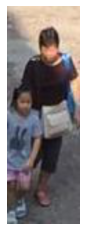

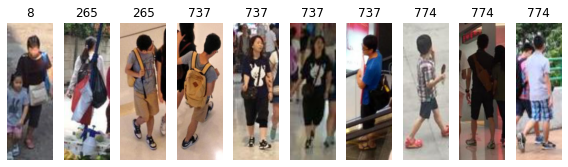

204
The person is at the beach and standing on one leg while wearing a black tank top.


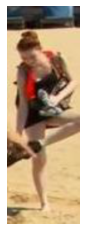

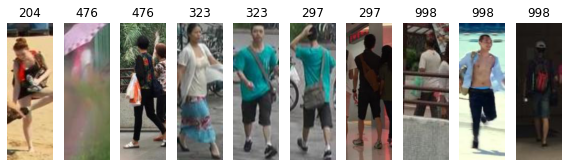

390
The guy has a bag around his shoulder and is wearing a black top and black pants with sneakers.


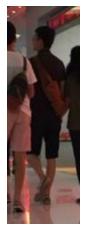

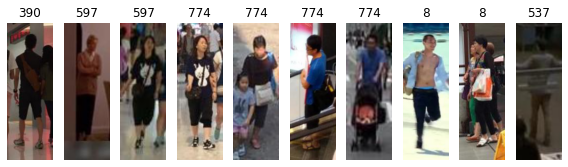

419
The man is wearing a yellow shirt, tan pants and brown shoes.he is also carrying a dark grey backpack.


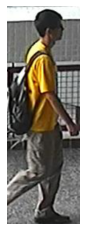

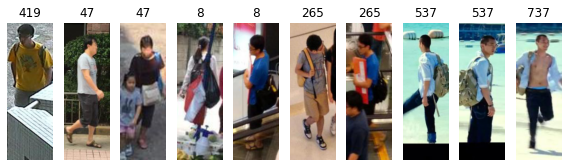

537
A man wearing a blue shirt, a pair of black pants, a black back pack and a pair of glasses.


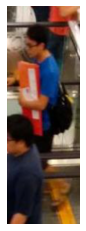

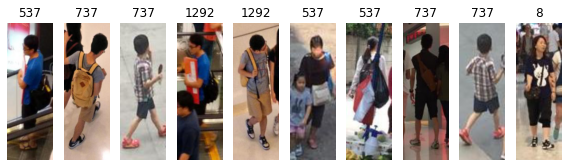

537
He has short black hair and is wearing a dark blue shirt. He is also wearing black pants and open toed shoes.


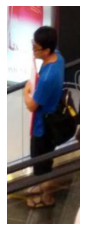

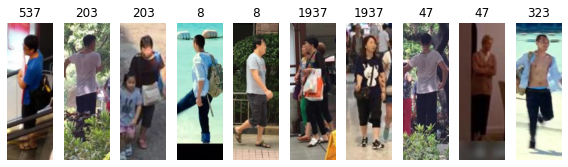

737
A man wearing a Gray shirt with writing on the front of it, a pair of brown shorts and a pair of black and white shoes.


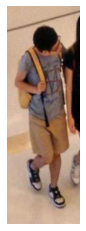

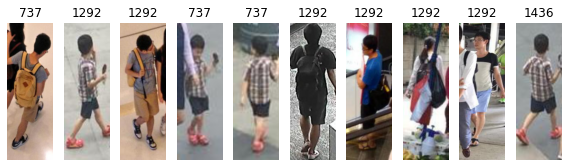

774
The woman has medium length brown hair, she is wearing a short sleeve black shirt, black pants, and black and white shoes.


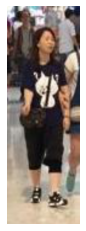

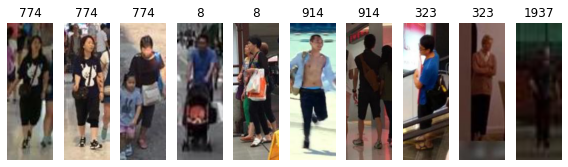

1081
The man is seen from behind with short black hair wearing a purple short sleeved shirt and black shorts, and carrying a white bag in his left hand.


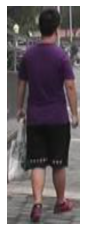

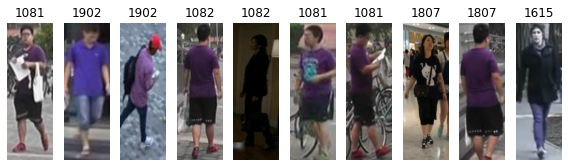

1615
The pedestrian with short, dark hair wears a purple shirt with athletic shorts and shoes.


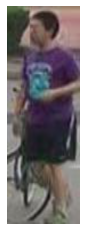

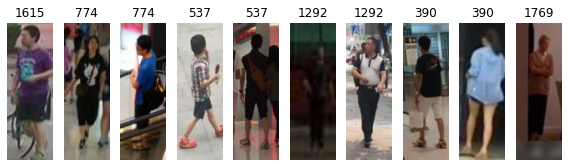

In [41]:
print_imgs = [8, 109, 197, 212, 267, 269, 392, 402, 591, 793]
columns = 10
rows = 1

for kk in print_imgs:
    plt.axis('off')
    plt.imshow(imgs[kk])
    print(ids[kk])
    print(orig_caps[kk])
    temp = mat[kk]
    temp = temp[:columns*rows*2]
    temp_imgs = imgs[temp]
    temp_ids = ids[temp]
    fig = plt.figure(figsize=(8, 8))
    
    count = 0
    for i in range(1, columns*rows +1):
        sub_temp = fig.add_subplot(rows, columns, i)
        sub_temp.title.set_text(temp_ids[i])
        plt.imshow(temp_imgs[(i-1)*2])
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [46]:
mat = mat.astype(np.int)
ids = ids.astype(np.int)
print("Matrix Ready")

compute_score(mat, ids)

Matrix Ready

Computing RankX
8
109
197
212
267
269
392
402
591
793
923
Rank1: 
0.01098901098901099
Rank5: 
0.03996003996003996
Rank10: 
0.060939060939060936
Rank20: 
0.0979020979020979
